# Machine Learning: Predicting Average Book Ratings Based on Book Covers

The goal of the machine learning portion of this project is to predict a book's average rating based on its book cover. Since rating is a quantitative value, we will be using regression models to predict scores.

In the data collection portion of this project, we scraped URLs to the book's cover images. In this notebook, we read those images in a 64x64x3 RGB array and flatten it into a 1-D arrays to use for our test and train data.

*NB: not all books had valid cover URLs, so the following models could only predict for the 23,975 books that did.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/Data Science Final Project/"

Mounted at /content/drive


In [ ]:
#read in data (Part 1 and Part 2 show how these csv files were created. ML model testing is in section 3)
df_books = pd.read_csv(data_dir + "books_clean.csv")
df_images = pd.read_csv(data_dir + "book_covers_full.csv")

# Part 1: Transforming image data into a 1-D array

To do this, we needed to standardize the size of the book cover images -- we chose to compress all images using billinear interpolation to preserve the key features (color, shape, all aspects of the cover) and stored all the book covers at 64x64 images. We did this because 64x64x3 (=12288 features) was most compatible with the number of observations we had -- larger images (like 128x128x3=49152) would mean our model has more features than training observations, which would not yield good predictions.

Moreover, we found that a 64x64 image was clearer than a 32x32, and so was critical to maintain a good level of key distinguishing features between each book.

### Reading images from URL & resizing to prepare for ML model
1. Define functions to read and resize image
2. Determine the optimal size for the images (64x64)

In [ ]:
image_urls1 = df_books.loc[df_books["image_url"] != "", "image_url"]

In [ ]:
import requests
from PIL import Image
from io import BytesIO
from skimage.io import imread
from skimage.transform import resize

def read_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img_array = np.array(img)
    return img_array

In [ ]:
def resize_image(image_array, new_size):
    """
    Resize image array to a new size using bilinear interpolation.
    
    Parameters:
    - image_array: numpy array representing the image
    - new_size: tuple representing the new size (width, height)
    
    Returns:
    - resized_image_array: numpy array representing the resized image
    """
    # Convert numpy array to PIL Image object
    image = Image.fromarray(image_array)
    
    # Resize image using bilinear interpolation
    resized_image = image.resize(new_size, resample=Image.BILINEAR)
    
    # Convert PIL Image object to numpy array
    resized_image_array = np.array(resized_image)
    
    return resized_image_array

# Part 2: Load a DataFrame of image arrays for each book, the book title & average rating

In [ ]:
image_size = (64, 64)

image_urls = image_urls1[:12000]

# Define a lambda function that reads an image from a URL, resizes it, and flattens it
read_resize_flatten_image = lambda url: resize(imread(url), image_size).flatten()

# make a list of flattened image arrays with size 12288 and corresponding book indices
image_arrays = []
book_titles = []
for i, url in enumerate(image_urls):
    flattened_image = read_resize_flatten_image(url)
    if flattened_image.size == 12288:
        image_arrays.append(flattened_image)
        book_titles.append(df_books["title"][i])

# Create a DataFrame with flattened image arrays and book indices
df_images = pd.DataFrame(np.vstack(image_arrays))
df_images['rating'] = [df_books.iloc[idx]['avg_rating'] for idx in range(len(image_arrays))]
df_images['title'] = book_titles

df_images.to_csv(data_dir + 'book_covers.csv', index=False)

#second half of data -- so that colab does not exceed output size limit

split = 24971 - 12000

image_urls = image_urls1[split:]

# Define a lambda function that reads an image from a URL, resizes it, and flattens it
read_resize_flatten_image = lambda url: resize(imread(url), image_size).flatten()

# make a list of flattened image arrays with size 12288 and corresponding book indices
image_arrays = []
book_titles = []
for i, url in enumerate(image_urls):
    flattened_image = read_resize_flatten_image(url)
    if flattened_image.size == 12288:
        image_arrays.append(flattened_image)
        book_titles.append(df_books["title"][i])

# Create a df with flattened image arrays and book indices
df_images = pd.DataFrame(np.vstack(image_arrays))
df_images['rating'] = [df_books.iloc[idx]['avg_rating'] for idx in range(len(image_arrays))]
df_images['title'] = book_titles

df_images.to_csv(data_dir + 'add_book_covers.csv', index=False)

In [ ]:
book_covers = "/content/drive/MyDrive/Data Science Final Project/book_covers.csv"
add_book_covers = "/content/drive/MyDrive/Data Science Final Project/add_book_covers.csv"

df1 = pd.read_csv(book_covers)
df2 = pd.read_csv(add_book_covers)

df_images = pd.concat([df1, df2], axis=0)

In [ ]:
df_images.to_csv(data_dir + 'book_covers_full.csv', index=False)

In [ ]:
print(f"The number of books with a valid book cover are {len(df_images)}")

The number of books with a valid book cover are 23975


Now that we have flattened and stacked the image pixel data, we expect to see a dataframe with 12288 (64x64x3) columns for each pixel + 2 more columns for the book title and its rating. 

To check for this, we call .shape to ensure there are 12,290 columns


In [ ]:
df_images.shape

(23975, 12290)

# Part 3: Model testing

# Hyperparameter testing of K-nearest-neighbors model
In this section, K-Neighbors Regressor: best K value?

In [ ]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
X_train = df_images.iloc[:,: 12287]
y_train = df_images["rating"]

The trends of training and test MSEs follow what we would expect -- that test MSE is always higher than training MSE. We will zoom in on the 150-500 range as that seems to be more promising for a lower test MSE

470    0.116348
480    0.116357
460    0.116370
490    0.116389
440    0.116402
Name: Test MSE, dtype: float64


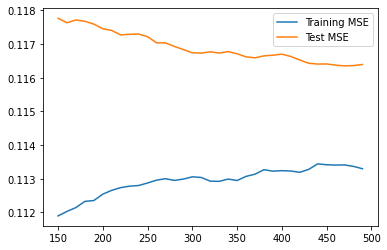

In [ ]:
ks = range(150, 500, 10)
train_MSEs = []
test_MSEs = []

for k in ks:
  model = KNeighborsRegressor(n_neighbors=k)
  model.fit(X_train,y_train)

  #computing train error
  y_train_pred = model.predict(X_train)
  train_MSEs.append(mean_squared_error(y_train, y_train_pred))

  test_MSEs.append(-cross_val_score(
      model, X_train, y_train,
      scoring="neg_mean_squared_error", cv=10).mean())

#get MS errors
MSEs = pd.DataFrame({
"Training MSE": train_MSEs,
"Test MSE": test_MSEs}, index=ks)
MSEs.plot.line(legend=True)

print(MSEs["Test MSE"].sort_values()[:5])

In [ ]:
#which scaling metric is the best

X_train = df_images.iloc[:,: 12287]
y_train = df_images["rating"]

col_transformer = make_column_transformer(
    (StandardScaler(), slice(0, 12287))
)

for metric in ['euclidean', 'manhattan']:
  pipeline = make_pipeline(col_transformer, KNeighborsRegressor(n_neighbors=470, metric=metric))

  print(metric, -cross_val_score(
      pipeline, X_train, y_train,
      scoring="neg_mean_squared_error",
      cv=10).mean()
  )

euclidean 0.11302739879961377
manhattan 0.11291609145348043


##Explore different features
### Comparing model trained on image features against non-image features

Can we judge a book by its cover? The cover of a book is more than just the image itself: it contains the book title and the author name!

In this section, we compare including these different feautres in a regression model. Using KNN, we compare models using only non-image features vs using image features.

Having determined the optimal value of k at k=470, we will  compare how the model fares between training only on book cover images versus other features like: author name, title, book description, and first sentence.

For this, we will disaggregate the data along genre-lines to better account for differences in genres. We will focus the model on the most common genre in the dataset: Fiction, which comprises 'fiction and literature' and "general fiction".

In [ ]:
top_genres = df_books['genre'].explode().value_counts().head(3)
print(f"most common genres:\n{top_genres}")

most common genres:
Fiction and Literature    19960
General Fiction            6346
Fantasy                    3735
Name: genre, dtype: int64


We see that 'fiction' features prominently across the top 5 most popular genres in the dataset. We will combine 'Fiction & Literature' and "General Fiction' in order to see a broader range of books. 

In [ ]:
df_fiction = pd.concat([pd.read_csv("/content/drive/MyDrive/Data Science Final Project/df_Fiction and Literature"), 
                        pd.read_csv("/content/drive/MyDrive/Data Science Final Project/df_General Fiction")])

df_fiction = df_fiction.drop_duplicates().dropna()

print(f"There are {len(df_fiction)} books in the Fiction category")

There are 14747 books in the Fiction category


In [ ]:
#define features
cat_vars = ['author', 'publication_year']
tfidf_vars = ['title', 'description', 'first_sentence']
y_train = df_fiction['avg_rating']

In [ ]:
preprocessors = [
    (OneHotEncoder(handle_unknown="ignore"), cat_vars),
    (TfidfVectorizer(max_features=50), tfidf_vars)
]
preprocessors[1]

(TfidfVectorizer(max_features=50), ['title', 'description', 'first_sentence'])

In [ ]:
column_transformers = [make_column_transformer((StandardScaler(), ["number_of_reviews"]),
    remainder="drop" 
), make_column_transformer(
    (StandardScaler(), ["number_of_reviews"]),
    (TfidfVectorizer(max_features = 100), 'description'),
    (TfidfVectorizer(max_features = 100), 'title'),
    remainder="drop" 
), make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"),['author']),
    (TfidfVectorizer(max_features = 100), 'title'),
    remainder="drop"  
), make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"),['author']),
    (TfidfVectorizer(max_features = 100), 'first_sentence'),
    (TfidfVectorizer(max_features = 100), 'description'),
    (TfidfVectorizer(max_features = 100), 'title'),
    remainder="drop"  
)]

for model_num, column_transformer in enumerate(column_transformers):
    pipeline = make_pipeline(
        column_transformer,
        KNeighborsRegressor(n_neighbors=20)
    )
    scores = cross_val_score(
        pipeline,
        X=df_fiction[['title', 'author', 'description', 'publication_year', 'first_sentence', 'number_of_reviews']],
        y=df_fiction['avg_rating'], 
        scoring="neg_mean_squared_error", 
        cv=20
    )
    error = -scores.mean()
    print(f"Error of model #{model_num + 1}: {error}")


Error of model #1: 0.08310826050452651
Error of model #2: 0.0789037170645755
Error of model #3: 0.08443445922383648
Error of model #4: 0.08125552210820897


In [ ]:
for model_num, column_transformer in enumerate(column_transformers):
  print(f"{model_num + 1}: {column_transformers[model_num]}")

1: ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['number_of_reviews'])])
2: ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['number_of_reviews']),
                                ('tfidfvectorizer-1',
                                 TfidfVectorizer(max_features=100),
                                 'description'),
                                ('tfidfvectorizer-2',
                                 TfidfVectorizer(max_features=100), 'title')])
3: ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['author']),
                                ('tfidfvectorizer',
                                 TfidfVectorizer(max_features=100), 'title')])
4: ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
        

KEY FINDING: The best performing model used a combination of 'number_of_reviews' and 'description'. Additionally, all of these models outperformed the book cover data (RMSE = 0.11).